In [53]:
from sklearn.datasets import load_sample_images
import tensorflow as tf
import matplotlib.pyplot as plt

In [54]:
!wget https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py

--2025-04-14 02:35:07--  https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-14 02:35:08 (110 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [55]:
from helper_functions import plot_loss_curves

(np.float64(-0.5), np.float64(639.5), np.float64(426.5), np.float64(-0.5))

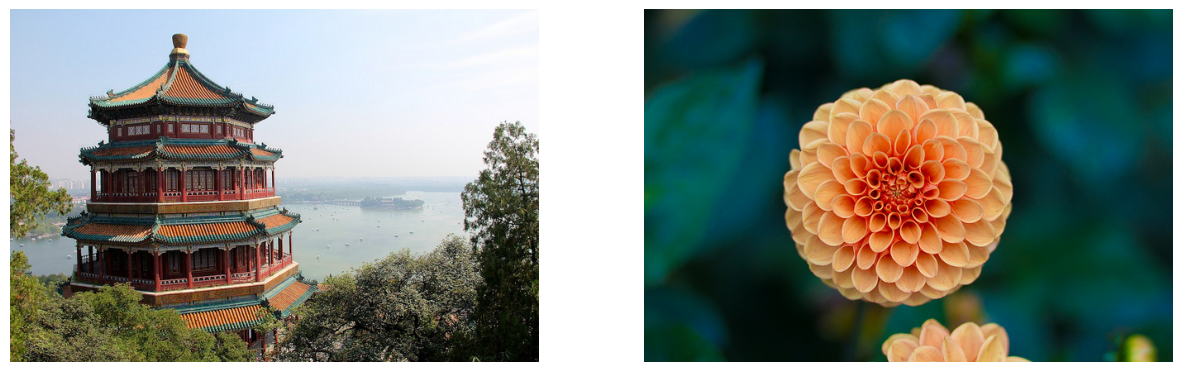

In [56]:
images = load_sample_images()['images']
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

(np.float64(-0.5), np.float64(119.5), np.float64(69.5), np.float64(-0.5))

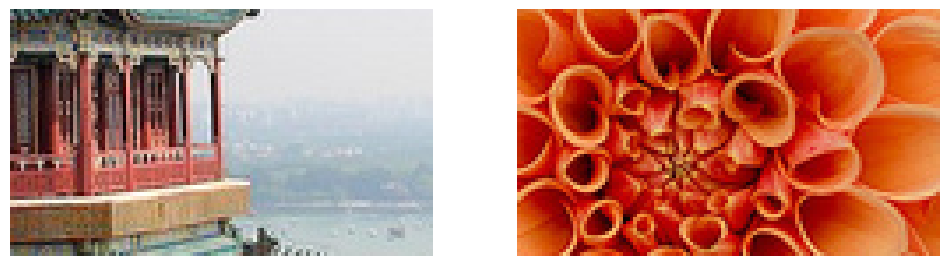

In [57]:
images = tf.keras.layers.CenterCrop(height=70,width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255.)(images)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

In [58]:
images.shape

TensorShape([2, 70, 120, 3])

In [59]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32,kernel_size=7)
fmaps = conv_layer(images)

In [60]:
fmaps.shape

TensorShape([2, 64, 114, 32])

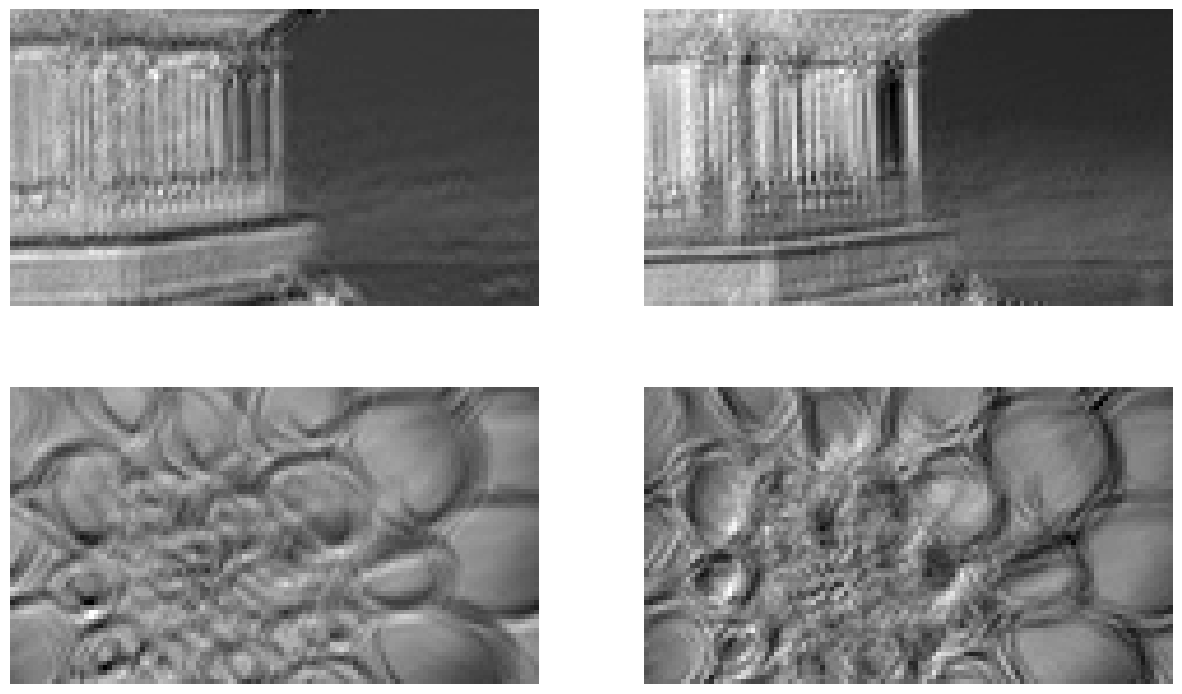

In [61]:
plt.figure(figsize=(15,9))
for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2,image_idx * 2 + fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx],cmap='gray')
    plt.axis('off')

plt.show()

In [62]:
conv_layer = tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding='same')
fmaps = conv_layer(images)

In [63]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [64]:
conv_layer = tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding='same',strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [65]:
import numpy as np

In [66]:
def conv_output_size(input_size,kernel_size,strides=1,padding='valid'):
  if padding == 'valid':
    z = input_size - kernel_size + strides
    output_size = z // strides
    num_ignored = z % strides
    return output_size, num_ignored
  else:
    output_size = (input_size - 1) // strides + 1
    num_padded = (output_size - 1) % strides + kernel_size - input_size
    return output_size, num_padded

conv_output_size(np.array([70,120]),kernel_size=10,strides=4,padding='same')

(array([18, 30]), array([ -59, -109]))

In [67]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [68]:
tf.random.set_seed(42)
filters = tf.random.normal([7,7,3,2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images,filters,strides=1,padding='SAME') + biases

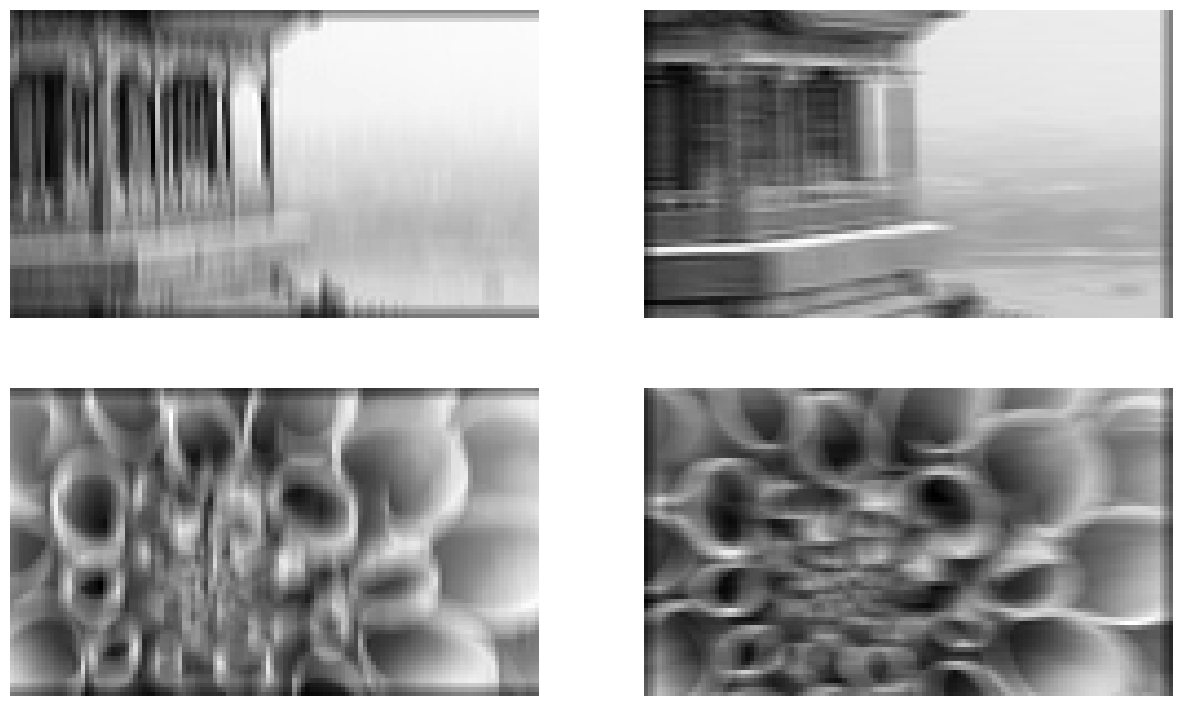

In [69]:
plt.figure(figsize=(15,9))
filters = np.zeros([7,7,3,2])
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1
fmaps = tf.nn.conv2d(images,filters,strides=1,padding='SAME') + biases
for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2,image_idx * 2 + fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx],cmap='gray')
    plt.axis('off')

plt.show()

# Implementing Pooling layes with Keras

# Max Pooling

In [70]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [71]:
output = max_pool(images)

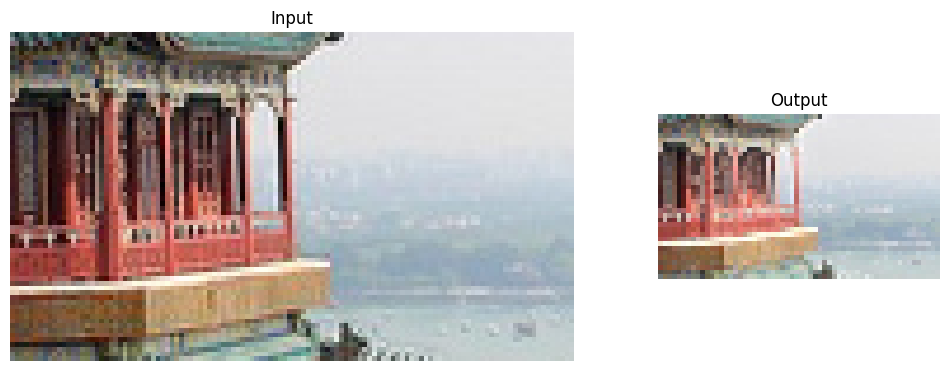

In [72]:
import matplotlib as mpl

fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1,ncols=2,width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title('Input')
ax1.imshow(images[0])
ax1.axis('off')

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title('Output')
ax2.imshow(output[0])
ax2.axis('off')
plt.show()

In [73]:
class DepthPool(tf.keras.layers.Layer):
  def __init__(self, pool_size=2, **kwargs):
    super().__init__(**kwargs)
    self.pool_size=pool_size

  def call(self, inputs):
    shape = tf.shape(inputs)
    groups = shape[-1] // self.pool_size
    new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
    return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

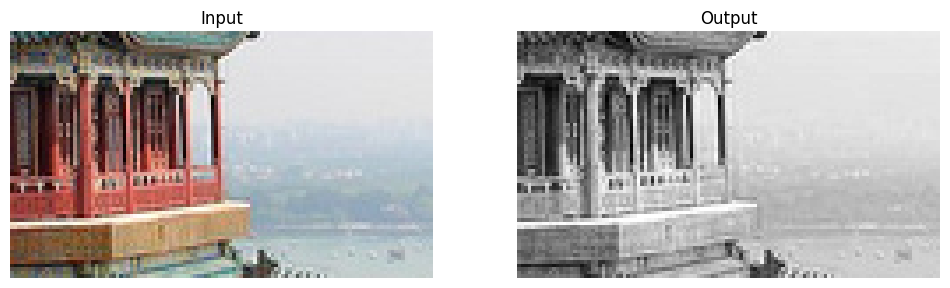

In [74]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Input')
plt.imshow(images[0])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Output')
plt.imshow(depth_output[0, ..., 0], cmap='gray')
plt.axis('off')
plt.show()

# CNN Architectures

# Tacklin Fashion MNIST with a CNN

In [75]:
mnist=tf.keras.datasets.fashion_mnist.load_data()
(X_train_full,y_train_full),(X_test,y_test)=mnist
X_train_full=np.expand_dims(X_train_full,axis=-1).astype(np.float32) / 255
X_test=np.expand_dims(X_test.astype(np.float32),axis=-1) / 255
X_train, X_valid=X_train_full[:-5000],X_train_full[-5000:]
y_train,y_valid=y_train_full[:-5000],y_train_full[-5000:]

In [76]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D=partial(tf.keras.layers.Conv2D,kernel_size=3,padding='same',activation='relu',kernel_initializer='he_normal')

model=tf.keras.Sequential([
    DefaultConv2D(filters=64,kernel_size=7,input_shape=[28,28,1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32,activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64,activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])
history=model.fit(X_train,y_train,epochs=10,
                  validation_data=(X_valid,y_valid))
score=model.evaluate(X_test,y_test)
X_new=X_test[:10]
y_pred=model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.0991 - loss: 2.3154 - val_accuracy: 0.0980 - val_loss: 2.3026
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.0969 - loss: 2.3028 - val_accuracy: 0.0980 - val_loss: 2.3026
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0973 - loss: 2.3028 - val_accuracy: 0.0980 - val_loss: 2.3026
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0972 - loss: 2.3038 - val_accuracy: 0.0980 - val_loss: 2.3027
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0974 - loss: 2.3029 - val_accuracy: 0.0980 - val_loss: 2.3026
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.0968 - loss: 2.3172 - val_accuracy: 0.0980 - val_loss: 2.3026
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0948 - loss: 2.3028 - val_accuracy: 0.0980 - val_loss: 2.3026
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0973 - loss: 2.

# Implementing a ResNet-34 CNN Using Keras

In [78]:
DefaultConv2D = partial(tf.keras.layers.Conv2D,kernel_size=3,strides=1,padding='same',kernel_initializer='he_normal',use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self,filters,strides=1,activation='relu',**kwargs):
    super().__init__(**kwargs)
    self.activation=tf.keras.activations.get(activation)
    self.main_layers=[
        DefaultConv2D(filters,strides=strides),
        tf.keras.layers.BatchNormalization(),
        self.activation,
        DefaultConv2D(filters),
        tf.keras.layers.BatchNormalization()
    ]

    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
          DefaultConv2D(filters,kernel_size=1,strides=strides),
          tf.keras.layers.BatchNormalization()
      ]

  def call(self,inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.main_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z+skip_Z)

In [79]:
model=tf.keras.Sequential([
    DefaultConv2D(64,kernel_size=7,strides=2,input_shape=[224,224,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')
])

prev_filters=64
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
  strides=1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters,strides=strides))
  prev_filters=filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_unit_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_unit_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_unit_13', however the la

# Using a Petrained Models from Keras

In [80]:
model=tf.keras.applications.ResNet50(weights='imagenet')

In [81]:
images=load_sample_images()['images']
images_resized=tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True)(images)

In [82]:
inputs=tf.keras.applications.resnet50.preprocess_input(images_resized)

In [83]:
Y_proba=model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(2, 1000)

In [84]:
Y_proba

array([[5.3595897e-07, 8.1552542e-05, 7.4939276e-06, ..., 5.6788362e-08,
        1.1921627e-04, 2.3534758e-05],
       [1.5941718e-07, 7.7845296e-05, 2.1639443e-07, ..., 6.2884892e-06,
        1.2104861e-05, 1.4500227e-05]], dtype=float32)

In [85]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba,top=3)
for image_index in range(len(images)):
  print(f'Image #{image_index}')
  for class_id,name,y_proba in top_K[image_index]:
    print(f' {class_id} - {name:12s} {y_proba:.2%}')

Image #0
 n03598930 - jigsaw_puzzle 30.68%
 n02782093 - balloon      17.17%
 n03888257 - parachute    5.57%
Image #1
 n04209133 - shower_cap   34.37%
 n09229709 - bubble       11.41%
 n02782093 - balloon      9.46%


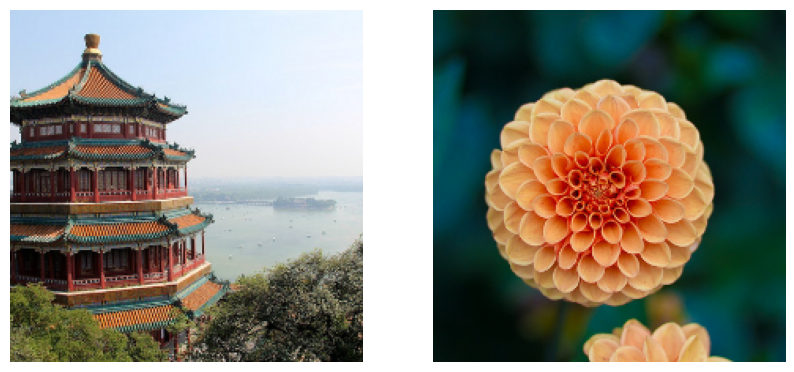

In [86]:
plt.figure(figsize=(10,6))
for idx in (0,1):
  plt.subplot(1,2,idx+1)
  plt.imshow(images_resized[idx] / 255)
  plt.axis('off')

plt.show()

In [87]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers",as_supervised=True,with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [88]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10]", "train[10%:25%]","train[25%:]"],
    as_supervised=True)

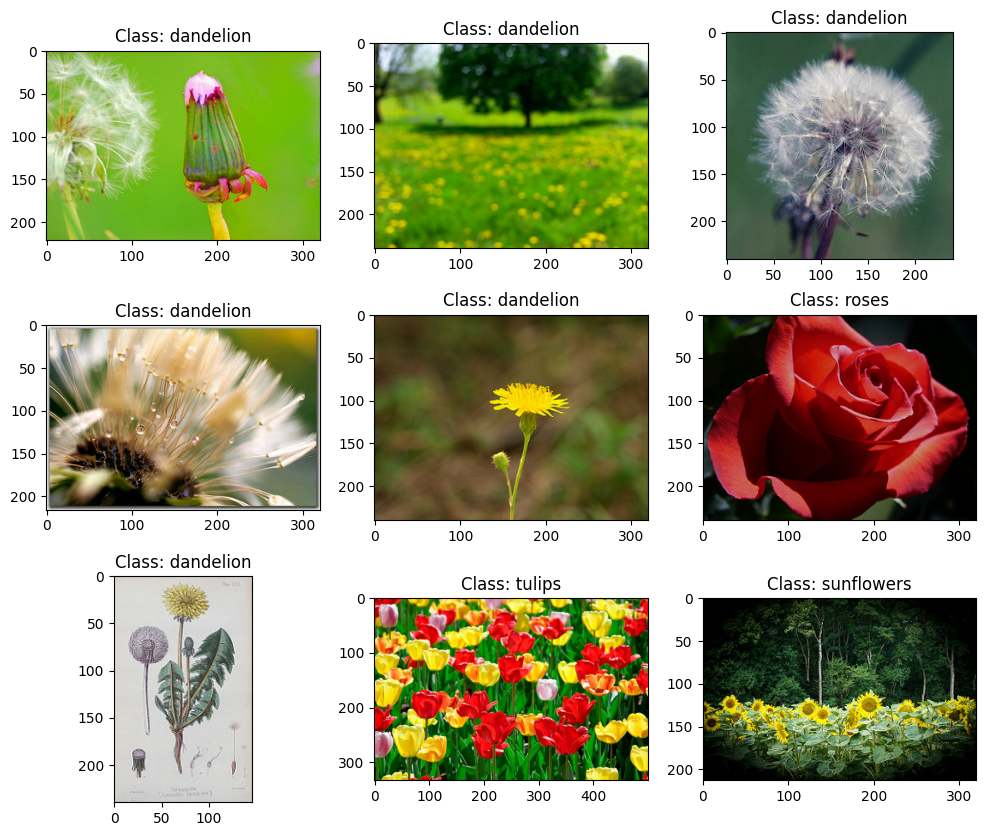

In [89]:
plt.figure(figsize=(12,10))
index=0
for image, label in valid_set_raw.take(9):
  index += 1
  plt.subplot(3,3,index)
  plt.imshow(image)
  plt.title(f'Class: {class_names[label]}')

plt.show()

In [90]:
tf.keras.backend.clear_session()

batch_size=32
preprocess=tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set=train_set_raw.map(lambda X,y:(preprocess(X),y))
train_set=train_set.shuffle(1000,seed=42).batch(batch_size).prefetch(1)
valid_set=valid_set_raw.map(lambda X,y: (preprocess(X),y)).batch(batch_size)
test_set=test_set_raw.map(lambda X,y: (preprocess(X),y)).batch(batch_size)

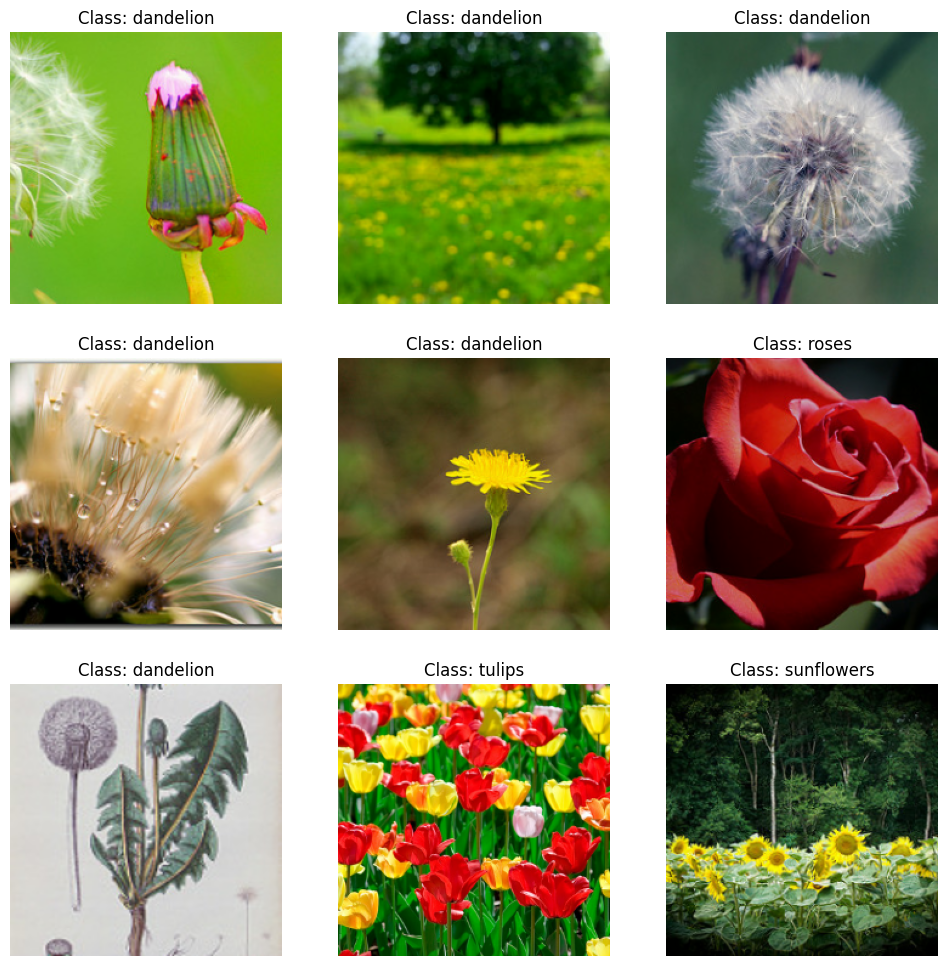

In [91]:
plt.figure(figsize=(12,12))
for X_batch,y_batch in valid_set.take(1):
  for index in range(9):
    plt.subplot(3,3,index+1)
    plt.imshow((X_batch[index] + 1) / 2)
    plt.title(f'Class: {class_names[y_batch[index]]}')
    plt.axis('off')

plt.show()

In [92]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal',seed=42),
    tf.keras.layers.RandomRotation(factor=0.05,seed=42),
    tf.keras.layers.RandomContrast(factor=0.2,seed=42)
])

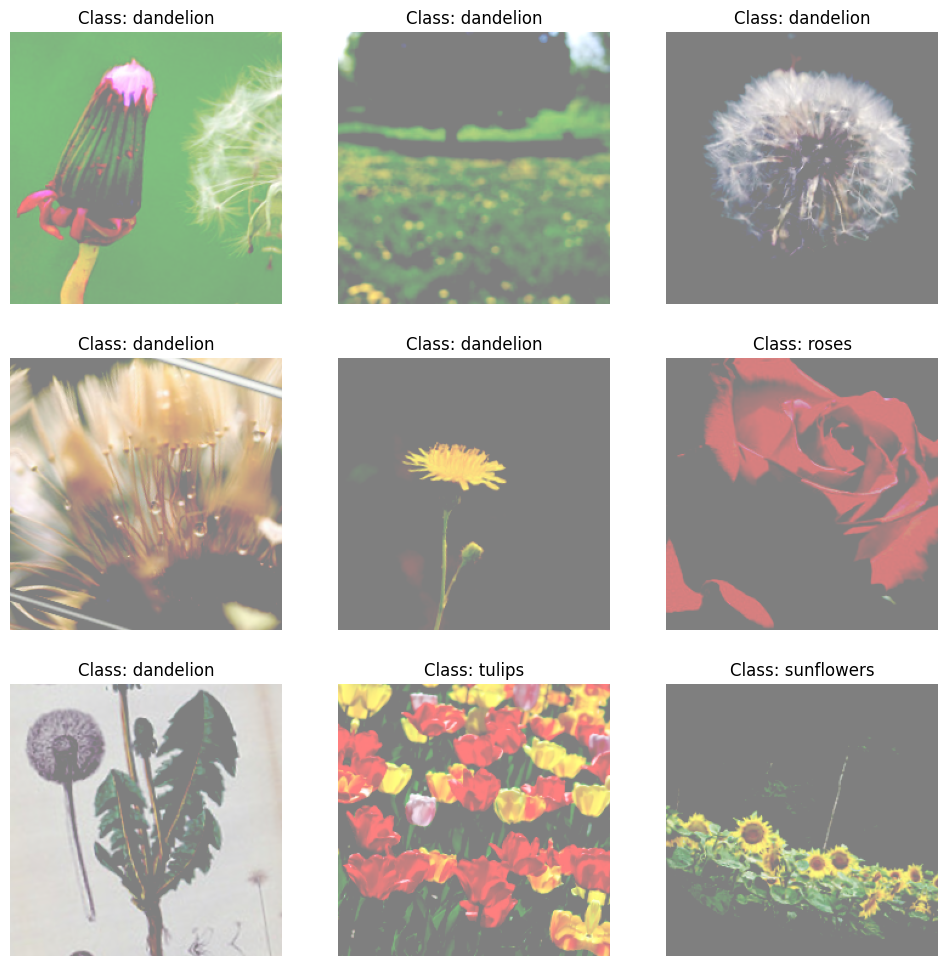

In [93]:
plt.figure(figsize=(12,12))
for X_batch,y_batch in valid_set.take(1):
  X_batch_augmented = data_augmentation(X_batch,training=True)
  for index in range(9):
    plt.subplot(3,3,index+1)
    # We must rescale the images to the 0-1 range ffor imshow(), and also
    # clip the result to that range because data augmentation may make some
    # values go out of bounds (e.g. RandomContrast in this case).
    plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
    plt.title(f'Class: {class_names[y_batch[index]]}')
    plt.axis('off')

plt.show()

In [94]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(include_top=False,weights='imagenet')
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes,activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input,outputs=output)

In [95]:
for layer in base_model.layers:
  layer.trainable=False

In [96]:
optimizer=tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history=model.fit(train_set,validation_data=valid_set,epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 206ms/step - accuracy: 0.6957 - loss: 1.0419 - val_accuracy: 0.8584 - val_loss: 0.6989
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.9004 - loss: 0.3916 - val_accuracy: 0.8367 - val_loss: 0.6906
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.9316 - loss: 0.2261 - val_accuracy: 0.8530 - val_loss: 0.6737


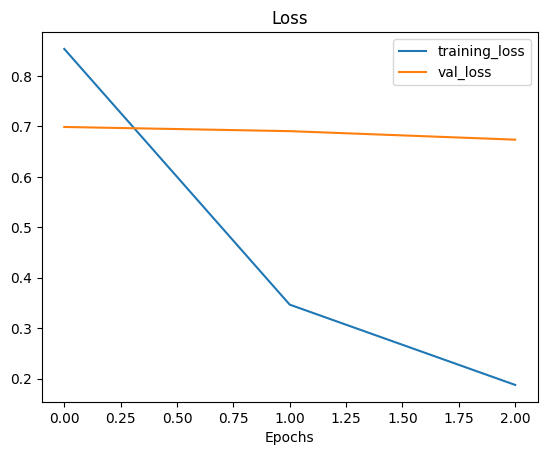

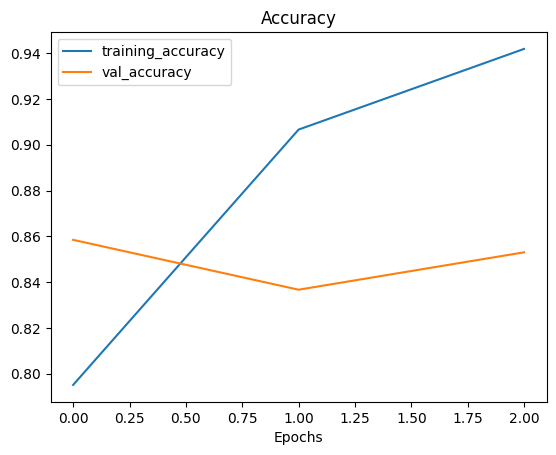

In [97]:
plot_loss_curves(history)

In [98]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
  for idx in indices:
    print(f'{idx:3}: {base_model.layers[idx].name:22}', end='')
  print()

  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [99]:
for layer in base_model.layers[56:]:
  layer.trainable=True

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 429ms/step - accuracy: 0.8647 - loss: 0.3920 - val_accuracy: 0.8693 - val_loss: 0.6135
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 69s 328ms/step - accuracy: 0.9770 - loss: 0.0812 - val_accuracy: 0.9129 - val_loss: 0.3702
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 311ms/step - accuracy: 0.9924 - loss: 0.0196 - val_accuracy: 0.9020 - val_loss: 0.3492
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - accuracy: 0.9950 - loss: 0.0122 - val_accuracy: 0.9201 - val_loss: 0.3075
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 28s 319ms/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 0.9183 - val_loss: 0.2975
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.9990 - loss: 0.0029 - val_accuracy: 0.9274 - val_loss: 0.2983
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.9987 - loss: 0.0029 - val_accuracy: 0.9220 - val_loss: 0.3146
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 318ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accu

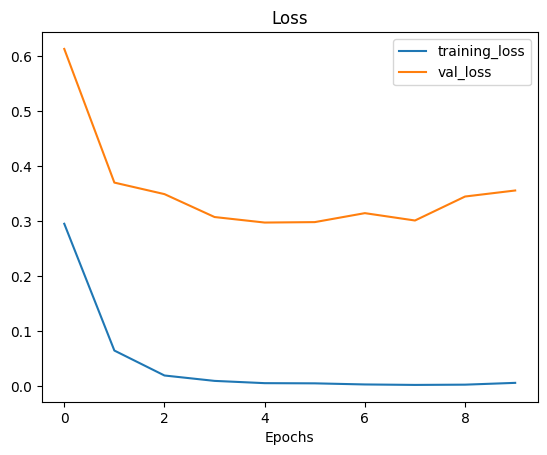

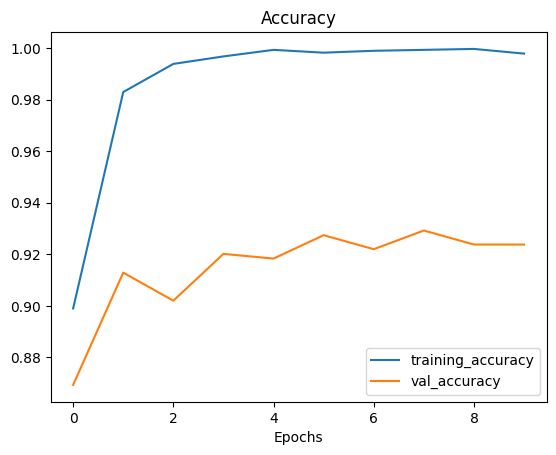

In [100]:
plot_loss_curves(history)

In [101]:
#tf.keras.layers.SeperableConv2D

In [102]:
#print('a', 'b', sep='|')